In [18]:
import torch
import torch.nn as nn
import torchvision
# import keras
# import tensorflow_datasets as tfds
import numpy as np
import sys
import matplotlib.pyplot as plt
sys.path.append('..')
import condense
import tqdm
import logging
logging.getLogger('condense').setLevel(logging.INFO)
condense.logger.setLevel(logging.INFO)



data = torchvision.datasets.MNIST('datasets',
                                  train=True,
                                  download=True, 
                                  transform=torchvision.transforms.ToTensor())
test = torchvision.datasets.MNIST('datasets',
                                  train=False,
                                  download=True, 
                                  transform=torchvision.transforms.ToTensor())

loader = torch.utils.data.DataLoader(data,
                                     batch_size=200,
                                     shuffle=True)

eval_loader = torch.utils.data.DataLoader(test,
                                         batch_size=100,
                                         shuffle=True)

Text(0.5, 1.0, 'After Fine Tuning')

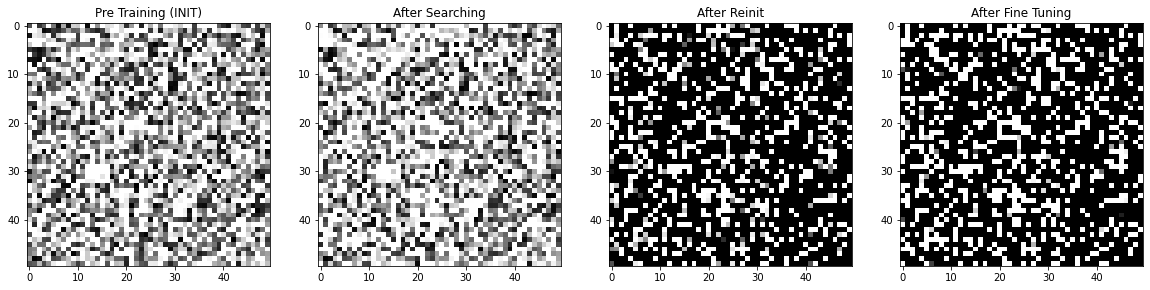

In [27]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=4, stride=2)
        self.layer2 = nn.Conv2d(in_channels=4, out_channels=2, kernel_size=2)
        self.dense = nn.Linear(288, out_features=50)
        self.dense2 = nn.Linear(50, out_features=50)
        self.output = nn.Linear(50, out_features=10)
    

    def forward(self, X):
        X = self.layer1.forward(X)
        X = self.layer2.forward(torch.relu(X))
        X = X.view(torch.relu(X).size(0), -1)
        X = self.dense.forward(torch.relu(X))
        X = self.dense2.forward(torch.relu(X))
        X = self.output.forward(torch.relu(X))
        return X
    
    def train(self, data, epochs=None, eval_data=None, lr=0.001):
        metrics = {
            "loss": [],
            "eval": []
        }
        criterion = nn.CrossEntropyLoss()
        optim = torch.optim.Adagrad(self.parameters(), lr=lr, weight_decay=0)
        for i, (X, y) in enumerate(data):
            if epochs and epochs < i:
                break
            self.zero_grad()
            pred = self.forward(X)
            l = criterion(pred, y)
            l.backward()
            optim.step()
            metrics['loss'].append(l)
            
            if eval_data:
                _, (X, y) = next(enumerate(data))
                metrics['eval'].append(criterion(self.forward(X), y))
                
        return metrics
            
net = Network()

pruned = condense.torch.PruningAgent(net, condense.optimizer.sparsity_functions.Constant(0.7), apply_mask=False, ignored_params=[net.output])
plt.figure(figsize=(20,5))
plt.subplot(1,4,1)

plt.imshow(np.abs(pruned.model.dense2.weight.detach().numpy()),vmin=0, vmax=0.1, cmap='gist_gray')
plt.title('Pre Training (INIT)')

with condense.torch.TicketSearch(pruned):
    search = net.train(loader, 100, eval_loader, lr=0.01)
    plt.subplot(1,4,2)
    plt.imshow(np.abs(pruned.model.dense2.weight.detach().numpy()),vmin=0, vmax=0.1, cmap='gist_gray')
    plt.title('After Searching')

plt.subplot(1,4,3)
plt.imshow(np.abs(pruned.model.dense2.weight.detach().numpy()),vmin=0, vmax=0.1, cmap='gist_gray')
plt.title('After Reinit')

    
met = pruned.model.train(loader, 300, eval_data=eval_loader, lr=0.01)
plt.subplot(1,4,4)
plt.imshow(np.abs(pruned.model.dense2.weight.detach().numpy()),vmin=0, vmax=0.1, cmap='gist_gray')
plt.title('After Fine Tuning')

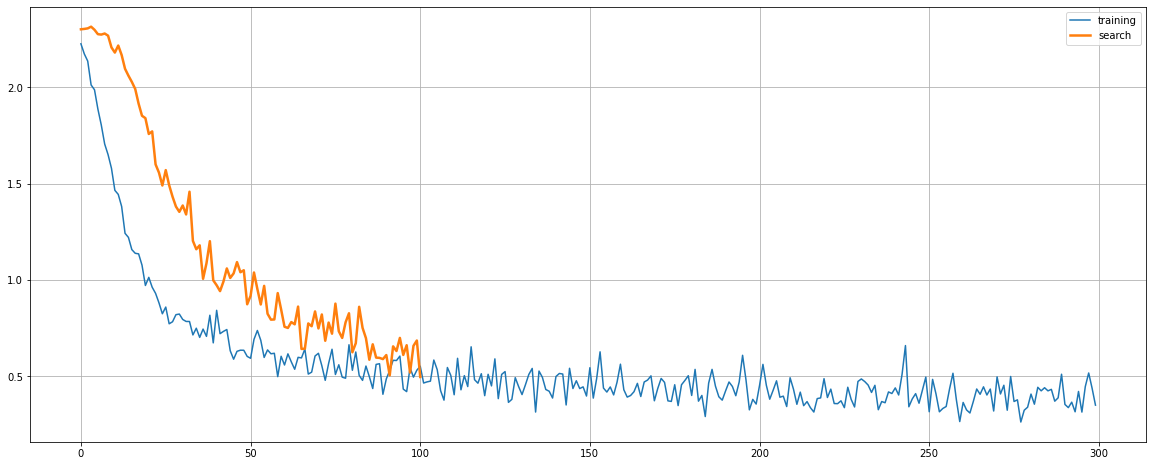

In [28]:
plt.figure(figsize=(20, 8))
# plt.plot(met['loss'], label='training', ls='--')
# plt.plot(search['loss'], label='search', ls='--')
plt.plot(met['eval'], label='training')
plt.plot(search['eval'], label='search', lw=2.5)
plt.legend()
plt.grid()

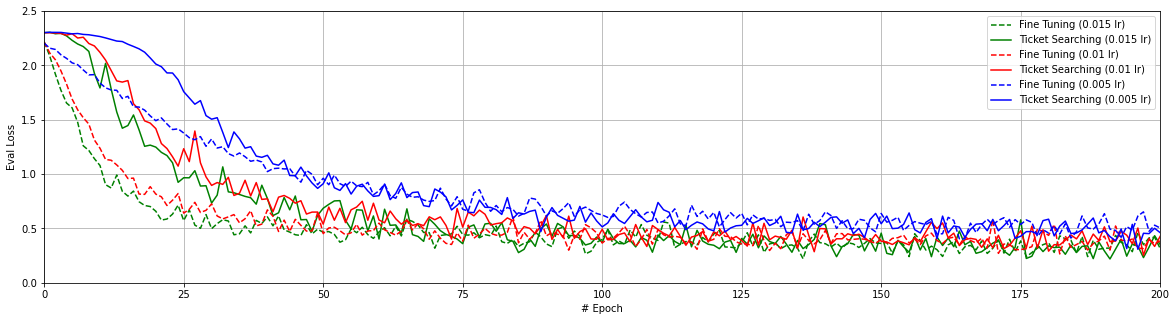

In [13]:
test_net = Network()

def test(lr):
    model = Network()
    model.load_state_dict(test_net.state_dict())
    p = condense.torch.PruningAgent(model, condense.optimizer.sparsity_functions.Constant(0.7), apply_mask=False, ignored_params=[model.output])

    with condense.torch.TicketSearch(p):
        search = model.train(loader, 200, eval_loader, lr=lr)
        
    return model.train(loader, 300, eval_loader, lr=lr), search

    
plt.figure(figsize=(20,5))
for lr, c in zip([0.015, 0.01, 0.005], ['green', 'red', 'blue']):
    train, search = test(lr)
    plt.plot(train['eval'], label=f'Fine Tuning ({lr} lr)', ls='--', c=c)
    plt.plot(search['eval'], label=f'Ticket Searching ({lr} lr)', c=c)

plt.axis([0, 200, 0, 2.5])
plt.grid()
plt.xlabel('# Epoch')
plt.ylabel('Eval Loss')
plt.legend()